In [20]:
import numpy as np
import pandas as pd
from sklearn import metrics
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px
import optuna
import sys
sys.path.append("../models + metrics/")
from kMeans import kMeans
import diffusion_map
from clustering_metrics import intrinsic_metrics, extrinsic_metrics

In [21]:
data = pd.read_csv("../data/politifact_all.csv")
data

,Unnamed: 0,id,news_url,title,tweet_ids,label
0,0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0
...,...,...,...,...,...,...
1051,619,politifact14731,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN,1
1052,620,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,1
1053,621,politifact1576,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN,1
1054,622,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,1


In [3]:
flat_embeddings = np.load("../data/politifact_embeddings.npy")
num_cols = int(flat_embeddings.size / len(data))
X = flat_embeddings.reshape(len(data), int(num_cols))
X.shape

(1056, 384)

In [4]:
ground_truths = data.label

In [8]:
def objective(trial):
    num_dimensions = trial.suggest_int("num_components", 1, 20)
    num_clusters = trial.suggest_int("k", 2, 10)
    sigma = trial.suggest_categorical("sigma", [0.25, 0.5, 1, 5, 10])
    #diffusion map
    diff_map = diffusion_map.DiffusionMap(dim=num_dimensions, sigma=sigma, distance="euclidean")
    reduced_data = diff_map.map(X)    
    #cluster
    clusterer = kMeans(k=num_clusters)
    clusterer.train(reduced_data, ground_truths)
    predict_labels = clusterer.labels
    # rand score
    return metrics.rand_score(ground_truths, predict_labels)

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-01 22:14:29,926] A new study created in memory with name: no-name-a8636297-4a58-432b-bf5a-799f4f5b3d3a
[I 2022-06-01 22:14:30,794] Trial 0 finished with value: 0.5124102398391498 and parameters: {'num_components': 18, 'k': 9, 'sigma': 0.25}. Best is trial 0 with value: 0.5124102398391498.
[I 2022-06-01 22:14:31,618] Trial 1 finished with value: 0.5800104121786587 and parameters: {'num_components': 3, 'k': 4, 'sigma': 5}. Best is trial 1 with value: 0.5800104121786587.
[I 2022-06-01 22:14:32,479] Trial 2 finished with value: 0.5150043084877208 and parameters: {'num_components': 9, 'k': 10, 'sigma': 10}. Best is trial 1 with value: 0.5800104121786587.
[I 2022-06-01 22:14:33,320] Trial 3 finished with value: 0.6415068935803533 and parameters: {'num_components': 8, 'k': 5, 'sigma': 0.5}. Best is trial 3 with value: 0.6415068935803533.
[I 2022-06-01 22:14:34,157] Trial 4 finished with value: 0.5132898894154818 and parameters: {'num_components': 18, 'k': 5, 'sigma': 10}. Best is t

[I 2022-06-01 22:15:06,872] Trial 41 finished with value: 0.4957471635789171 and parameters: {'num_components': 2, 'k': 4, 'sigma': 5}. Best is trial 3 with value: 0.6415068935803533.
[I 2022-06-01 22:15:07,850] Trial 42 finished with value: 0.4957471635789171 and parameters: {'num_components': 2, 'k': 4, 'sigma': 5}. Best is trial 3 with value: 0.6415068935803533.
[I 2022-06-01 22:15:08,829] Trial 43 finished with value: 0.5680938532241849 and parameters: {'num_components': 3, 'k': 5, 'sigma': 5}. Best is trial 3 with value: 0.6415068935803533.
[I 2022-06-01 22:15:09,791] Trial 44 finished with value: 0.6036999138302456 and parameters: {'num_components': 8, 'k': 3, 'sigma': 5}. Best is trial 3 with value: 0.6415068935803533.
[I 2022-06-01 22:15:10,747] Trial 45 finished with value: 0.5018526497199483 and parameters: {'num_components': 11, 'k': 2, 'sigma': 10}. Best is trial 3 with value: 0.6415068935803533.
[I 2022-06-01 22:15:11,733] Trial 46 finished with value: 0.5156451960361913 a

[I 2022-06-01 22:15:48,905] Trial 83 finished with value: 0.6088934367370387 and parameters: {'num_components': 8, 'k': 6, 'sigma': 0.5}. Best is trial 80 with value: 0.678434223754129.
[I 2022-06-01 22:15:49,906] Trial 84 finished with value: 0.6091681028292403 and parameters: {'num_components': 6, 'k': 6, 'sigma': 0.5}. Best is trial 80 with value: 0.678434223754129.
[I 2022-06-01 22:15:50,910] Trial 85 finished with value: 0.5240216142467328 and parameters: {'num_components': 12, 'k': 4, 'sigma': 5}. Best is trial 80 with value: 0.678434223754129.
[I 2022-06-01 22:15:51,984] Trial 86 finished with value: 0.6078217004164872 and parameters: {'num_components': 7, 'k': 5, 'sigma': 0.5}. Best is trial 80 with value: 0.678434223754129.
[I 2022-06-01 22:15:52,961] Trial 87 finished with value: 0.5028489875053856 and parameters: {'num_components': 8, 'k': 3, 'sigma': 10}. Best is trial 80 with value: 0.678434223754129.
[I 2022-06-01 22:15:53,960] Trial 88 finished with value: 0.603103906362

In [10]:
print("Best hyperparameters are:", study.best_params)
print("Best score is:", study.best_value)

Best hyperparameters are: {'num_components': 9, 'k': 5, 'sigma': 0.5}
Best score is: 0.678434223754129


In [22]:
diff_map = diffusion_map.DiffusionMap(dim=4, sigma=5, distance="cosine")
reduced_data = diff_map.map(X)   

In [23]:
clusterer = kMeans(k=2)
clusterer.train(reduced_data, ground_truths)
predict_labels = clusterer.labels

In [24]:
intrinsic_metrics(X, predict_labels)

Sillhouette score: 0.025660723
Calinski-Harabasz Index: 28.077470387417236
Davies-Bouldin Index: 6.118025397456381


[0.025660723, 28.077470387417236, 6.118025397456381]

In [25]:
extrinsic_metrics(ground_truths, predict_labels)

Random Index: 0.6914853511417492
Homogeneity: 0.32213388678944127


[0.6914853511417492, 0.32213388678944127]

In [26]:
data.label[predict_labels==0].value_counts()

1    475
0     52
Name: label, dtype: int64

In [27]:
data.label[predict_labels==1].value_counts()

0    380
1    149
Name: label, dtype: int64

In [28]:
label_0_text = data.title[predict_labels==0]
label_1_text = data.title[predict_labels==1]

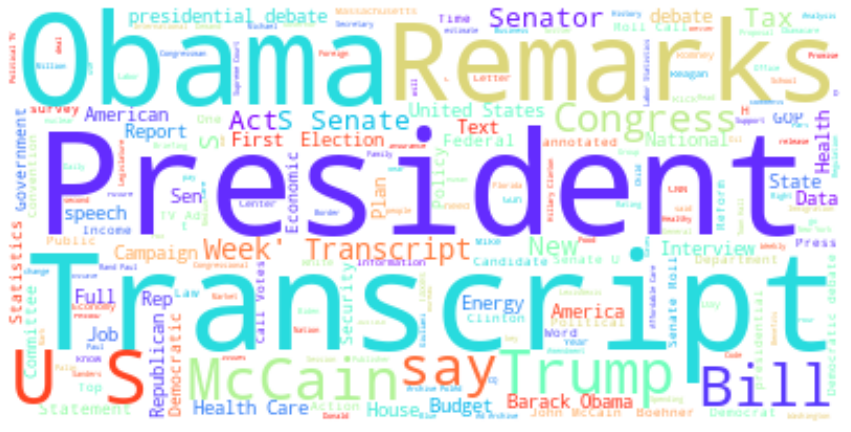

In [29]:
# cluster for true
text = " ".join(i for i in label_0_text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color = 'white', colormap='rainbow').generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

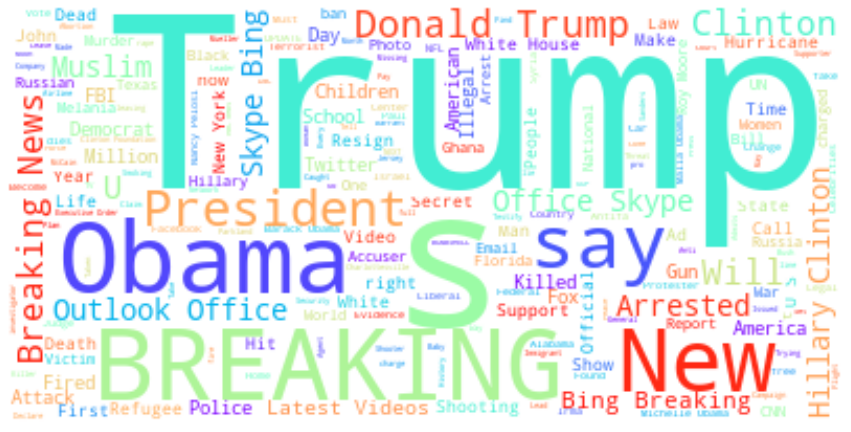

In [31]:
# cluster for false
text = " ".join(i for i in label_1_text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap="rainbow").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()